In [1]:
import os
import re
import json
import socket
import subprocess
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import utils as pu
from pyspark.sql import functions as F
from pyspark.sql import types as pt

## Assignment #1 

This task rely on to 

In [2]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf().set('spark.master', 'local[*]').set('spark.driver.memory', '4g').set("spark.executor.instances", "4")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st061465/


22/05/20 10:52:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Songs 

The songs. Note that data is in unicode.

- song_id
- song_length: in ms
- genre_ids: genre category. Some songs have multiple genres and they are separated by |
- artist_name
- composer
- lyricist
- language


In [3]:
songs = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/songs.csv")

songs.limit(100).toPandas().head(10)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,None,None,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,None,3.0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0


## "Train" data

Some data of users listen history 

- msno: user id
- song_id: song id
- source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
- source_screen_name: name of the layout a user sees.
- source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
- target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .


In [4]:
listen_history = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/__DATA/big_data_2022/labs/kkbox-music-recommendation-challenge/train.csv")

#listen_history.show()
listen_history.limit(100).toPandas().head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,1
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,1
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,1


## Additional info on the songs

File is not in the folder :(
```python
songs = spark.read.option("header", "True")\
    .csv("file:///home/jovyan/malyutin_temp/kkbox-music-recommendation-challenge/song_extra_info.csv")

songs.limit(100).toPandas().head(10)
```

## Assignment:

PREFER DATA FRAME API(!)

Vision of result:
- self-sufficient jupyter notebook
- not only the code but n
- published on github 
- link to your github attached here https://docs.google.com/spreadsheets/d/1F8ScpCCiBaxiyZqDd09jn6t25pykiK8oauJbRuuA8Q4/edit?usp=sharing


Task 1: 
- Find out top-20 of most popular artist's in terms of: raw listens, unique users listens;

Task 2: 
- find out top-3 languages by num of raw listens
- build histogram of songs length by language / genre. What is the longest genre? What is more valuable in terms of length: language or genre? 

Deadlines:
- soft 17.05
- hard 24.05

#### Task 1

Find out top-20 of most popular artist's in terms of: raw listens, unique users listens

##### Approach:
`raw_listeners`: all the listeners who listened to songs written by certain atrists without correction for uniqueness, users may duplicate; 
`unique_listeners`: the listeners who listened to songs written by certain atrists with correction for unqieness, users cannot duplicate.

In [5]:
# Create a local temporary view with DataFrame
listen_history.createOrReplaceTempView("listen_history")
songs.createOrReplaceTempView("songs")

In [7]:
# Write an SQL-query
spark.sql("""
SELECT songs.artist_name as artist, count(msno) as raw_listeners, count(DISTINCT msno) as unique_listeners
FROM listen_history JOIN songs ON listen_history.song_id = songs.song_id
GROUP BY artist
ORDER BY raw_listeners desc
""").toPandas().head(20)

,artist,raw_listeners,unique_listeners
0,Various Artists,303617,22256
1,周杰倫 (Jay Chou),186776,18727
2,五月天 (Mayday),182088,18183
3,林俊傑 (JJ Lin),115325,17160
4,田馥甄 (Hebe),104946,18771
5,aMEI (張惠妹),82799,15169
6,陳奕迅 (Eason Chan),76035,16290
7,玖壹壹,70445,12487
8,G.E.M.鄧紫棋,67297,16064
9,BIGBANG,61927,10366


#### Task 2:

* find out top-3 languages by num of raw listens 

* build histogram of songs length by language / genre. 
    * What is the longest genre? 
    * What is more valuable in terms of length: language or genre?

##### Approach
* The same understanding of the term `raw_listeners` is used.
* I will first extract the dataframe I need, then transform it to the histogram; here I should note that it will not be exactly a histogram per se, more a `barchart`, since histogram is a type of a plot we use for only one variable and here we have two variables. Apart from that, I will need to divide `song_length` by 60000 to find the duration in minutes, right now it is in milliseconds. I will use the `songs` dataframe for this subtask.

In [8]:
# Write an SQL-query
spark.sql("""
SELECT songs.language as language, count(msno) as raw_listeners
FROM listen_history JOIN songs ON listen_history.song_id = songs.song_id
GROUP BY language
ORDER BY raw_listeners desc
""").toPandas().head(3)

,language,raw_listeners
0,3.0,4044643
1,52.0,1864788
2,31.0,656623


**Comment**: here I have noticed that some languages have similar codes; for example, 3.0 and 3. Is it a typo or are these different languages?

##### Creating a barchart for language-song_length

In [6]:
# Write an SQL-query
for_hist_lang = spark.sql("""
SELECT language, sum(song_length) as sum_songs_length_ms, mean(song_length) as mean_songs_length_ms
FROM songs
GROUP BY language
ORDER BY sum_songs_length_ms desc
""").toPandas()

In [7]:
# Have a look at the dataset
for_hist_lang['sum_songs_length_min'] = for_hist_lang['sum_songs_length_ms']/60000
for_hist_lang['mean_songs_length_min'] = for_hist_lang['mean_songs_length_ms']/60000
for_hist_lang.head()

,language,sum_songs_length_ms,mean_songs_length_ms,sum_songs_length_min,mean_songs_length_min
0,52.0,3.134235e+11,234476.641833,5.223725e+06,3.907944
1,-1.0,1.764514e+11,275935.120002,2.940857e+06,4.598919
2,3.0,2.594856e+10,244118.316393,4.324759e+05,4.068639
3,17.0,2.316844e+10,250420.907067,3.861407e+05,4.173682
4,24.0,9.963970e+09,238692.265787,1.660662e+05,3.978204


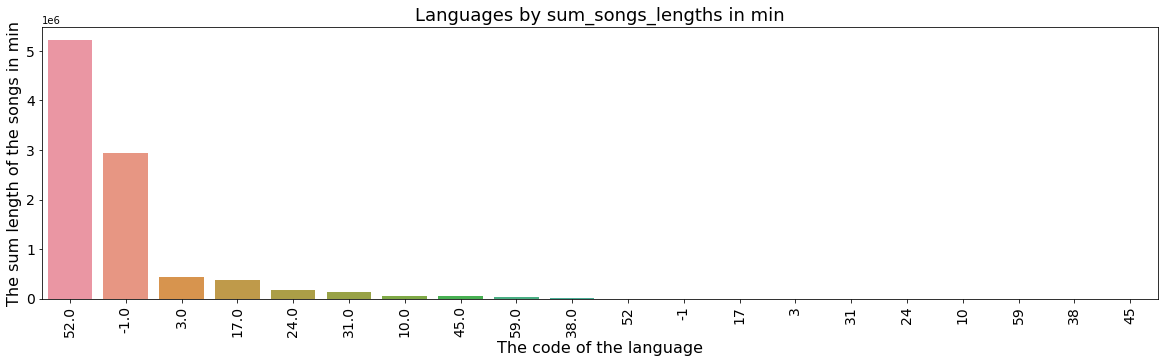

In [8]:
# Create a barchart for sum_songs_length_min 
fig, ax = plt.subplots(figsize=(20, 5))

sns.set_context('paper')
sns.barplot(x='language', y='sum_songs_length_min', data=for_hist_lang, ax=ax)
ax.set_title("Languages by sum_songs_lengths in min", fontsize=18) 

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('The code of the language', fontsize=16);
plt.ylabel('The sum length of the songs in min', fontsize=16)
plt.xticks(rotation=90)
plt.show()

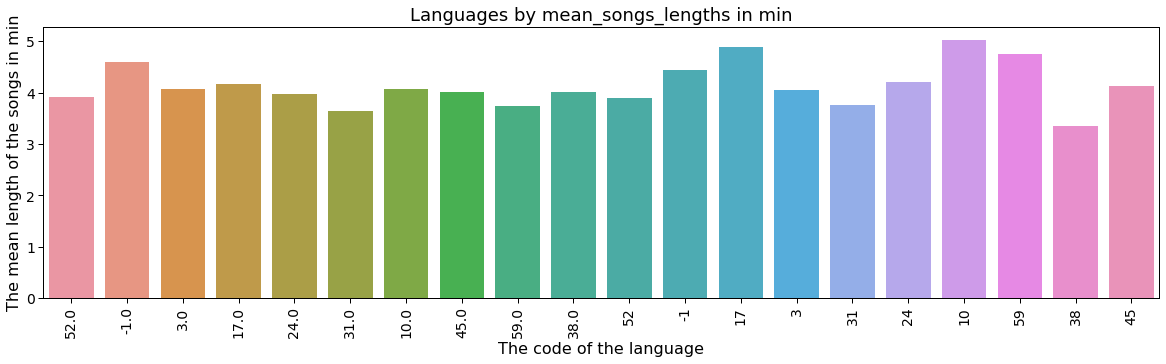

In [25]:
# Create a barchart for mean_songs_length_min 
fig, ax = plt.subplots(figsize=(20, 5))

sns.set_context('paper')
sns.barplot(x='language', y='mean_songs_length_min', data=for_hist_lang, ax=ax)
ax.set_title("Languages by mean_songs_lengths in min", fontsize=18) 

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('The code of the language', fontsize=16);
plt.ylabel('The mean length of the songs in min', fontsize=16)
plt.xticks(rotation=90)
plt.show()

##### Creating a barchart for genre-song_length

In [13]:
# Write an SQL-query
for_hist_genre = spark.sql("""
SELECT genre_ids, sum(song_length) as sum_songs_length_ms, count(song_length) as count_appearance
FROM songs
GROUP BY genre_ids
ORDER BY sum_songs_length_ms desc
""").toPandas()

In [14]:
# Have a look at the dataset
for_hist_genre['sum_songs_length_min'] = for_hist_genre['sum_songs_length_ms']/60000
for_hist_genre.tail(5)

,genre_ids,sum_songs_length_ms,count_appearance,sum_songs_length_min
1042,509|958,94563.0,1,1.576050
1043,1152|531,81113.0,1,1.351883
1044,1969|444|2100,51147.0,1,0.852450
1045,488|545,37709.0,1,0.628483
1046,545|873,24346.0,1,0.405767


**Comment**: here we have a problem that some songs have multiple genres divided by bars in genre_ids. Ideally we need to separate these genres. For example, the observation number ***1042*** has 2 genres: 509 and 958, `sum_songth_length_min` equals `1.576050`. We need to add this amount of minutes to each genre respectively, as well as `count_appearance`.

In [15]:
# Need this to delete None in genre_ids
for_hist_genre = for_hist_genre[~for_hist_genre['genre_ids'].isna()]

In [16]:
# 1 - genre, 3 -count_appearance, 4 - sum_songs_length_min
genres = dict()
for i in for_hist_genre.itertuples():
    if '|' in i[1]:
        for j in i[1].split('|'):
            if j in genres.keys():
                genres[j] = [genres[j][0] + i[4], genres[j][1] + i[3]]
            else:
                genres[j] = [i[4], i[3]]
    else:
        if i[1] in genres.keys():
            genres[i[1]] = [genres[i[1]][0] + i[4], genres[i[1]][1] + i[3]]
        else:
            genres[i[1]] = [i[4], i[3]]

In [17]:
# What is inside the dictionary
genres['465']

[2299058.352699998, 589334]

In [18]:
# Make a dataframe from a dictionary genres
df_genres = pd.DataFrame()
df_genres['genre'] = genres.keys()
df_genres['combined'] = genres.values()

In [19]:
# Take a look at the dataframe
df_genres.head(5)

,genre,combined
0,465,"[2299058.352699998, 589334]"
1,958,"[902792.5248166672, 182884]"
2,1609,"[855125.5055499994, 177297]"
3,2022,"[713407.9959166667, 176569]"
4,2122,"[629195.1273833337, 149645]"


In [20]:
# Prettify the dataset we got
df_genres = df_genres.combined.apply(pd.Series) \
    .merge(df_genres, left_index = True, right_index = True) \
    .drop(["combined"], axis = 1) \
    .rename(columns={0: "sum_songs_length_min", 1: "count_appearance"})

# Add the mean of songs' length in minutes
df_genres['mean_songs_length_min'] = df_genres["sum_songs_length_min"] / df_genres["count_appearance"]

In [21]:
# Take a look at the dataframe we got
df_genres = df_genres.sort_values(by='sum_songs_length_min', ascending=False)
df_genres.head()

,sum_songs_length_min,count_appearance,genre,mean_songs_length_min
0,2.299058e+06,589334.0,465,3.901113
1,9.027925e+05,182884.0,958,4.936422
2,8.551255e+05,177297.0,1609,4.823125
3,7.134080e+05,176569.0,2022,4.040392
4,6.291951e+05,149645.0,2122,4.204585


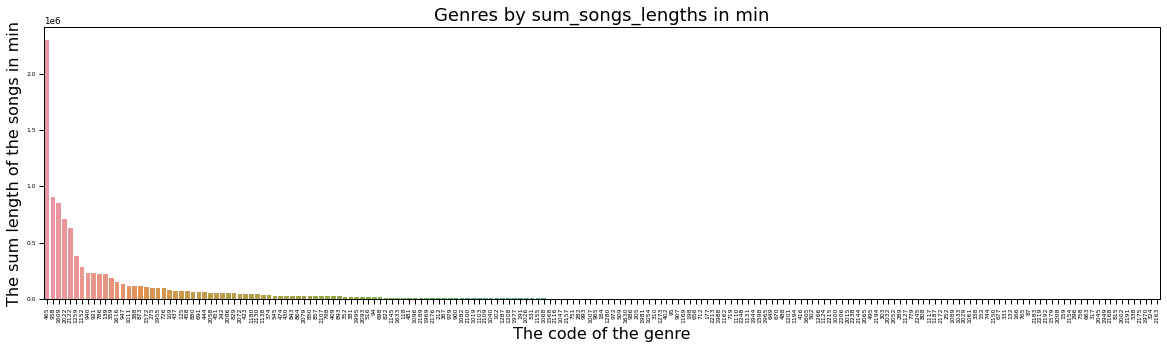

In [22]:
# Create a barchart for sum_songs_length_min: version 1
fig, ax = plt.subplots(figsize=(20, 5))

sns.set_context('paper')
sns.barplot(x='genre', y='sum_songs_length_min', data=df_genres, ax=ax)
ax.set_title("Genres by sum_songs_lengths in min", fontsize=18) 

plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('The code of the genre', fontsize=16);
plt.ylabel('The sum length of the songs in min', fontsize=16)
plt.xticks(rotation=90)
plt.show()

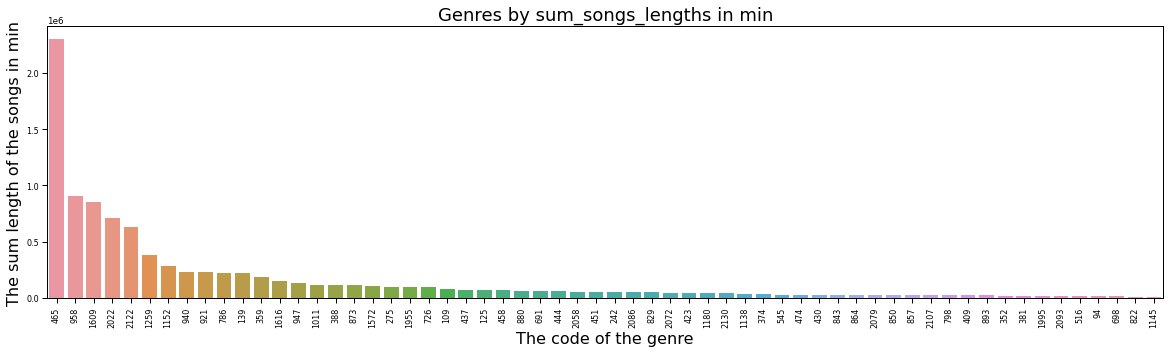

In [23]:
# To make it more readable, I will form a grath from a "shorter" dataset that will only contain ~30% of the initial dataset
# # Create a barchart for sum_songs_length_min: version 2
fig, ax = plt.subplots(figsize=(20, 5))

sns.set_context('paper')
sns.barplot(x='genre', y='sum_songs_length_min', data=df_genres.head(60), ax=ax)
ax.set_title("Genres by sum_songs_lengths in min", fontsize=18) 

plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('The code of the genre', fontsize=16);
plt.ylabel('The sum length of the songs in min', fontsize=16)
plt.xticks(rotation=90)
plt.show()

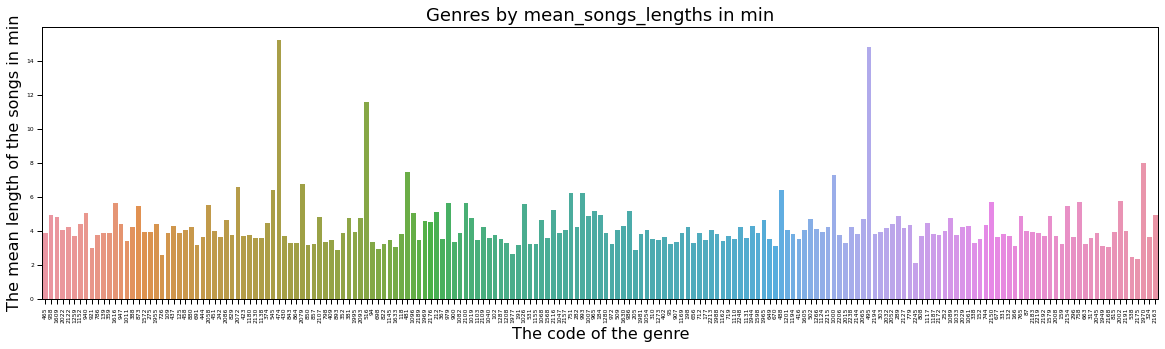

In [24]:
# Create a barchart for mean_songs_length_min: version 1
fig, ax = plt.subplots(figsize=(20, 5))

sns.set_context('paper')
sns.barplot(x='genre', y='mean_songs_length_min', data=df_genres, ax=ax)
ax.set_title("Genres by mean_songs_lengths in min", fontsize=18) 

plt.tick_params(axis='both', which='major', labelsize=6)
plt.xlabel('The code of the genre', fontsize=16);
plt.ylabel('The mean length of the songs in min', fontsize=16)
plt.xticks(rotation=90)
plt.show()

**Answer** to the question on `What is more valuable in terms of length: language or genre?`.

It depends on what you want to know. 

I would say that sum plots help to simply identify the most and the least popular language/genre which might be beneficial.

Mean plots seem more interesting though. For languages the songs' length is approxiamtely the same - average approximately equals 4 minutes, but for the genres in is a different story: there are definitely some **outlier**: the average songs' length for them seem to be noticably longer, for some even more than 20 minutes. 

So, in my opinion, **genre** is more valuable in terms of lenght.

P.S. I intentionally did not apply sorting to the mean plots, so that the reader can easily compare the sum and the mean plots.